# SSA Demonstration: Denoising, Trend Extraction, and Periodic Components

This notebook demonstrates the capabilities of the MKL-optimized SSA implementation:

1. **Denoising**: Separating signal from noise
2. **Trend Extraction**: Isolating underlying trends
3. **Periodic Extraction**: Identifying and extracting cyclical patterns
4. **Forecasting**: Predicting future values using LRF
5. **MSSA**: Multivariate analysis of correlated series

## Setup

First, ensure `libssa.so` is built:
```bash
source /opt/intel/oneapi/setvars.sh
gcc -shared -fPIC -O3 -o libssa.so ssa_wrapper.c \
    -DSSA_OPT_IMPLEMENTATION -DSSA_USE_MKL \
    -I${MKLROOT}/include -L${MKLROOT}/lib/intel64 -lmkl_rt -lm
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ssa_wrapper import SSA, MSSA

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

np.random.seed(42)

---
## 1. Denoising

SSA separates deterministic signal from stochastic noise by concentrating signal energy in the first few singular components.

In [2]:
def ensemble_denoise(signal, L_fractions=[1/4, 1/3, 2/5, 1/2], weights=None):
    """Ensemble SSA denoising with automatic cutoff."""
    N = len(signal)
    results = []
    
    for frac in L_fractions:
        L = int(N * frac)
        ssa = SSA(signal, L=L)
        k = min(60, L - 1)
        ssa.decompose(k=k)
        
        # Auto cutoff via cumulative variance
        var = [ssa.variance_explained(i, i) for i in range(k)]
        cumvar = np.cumsum(var) / sum(var)
        cutoff = np.searchsorted(cumvar, 0.95) + 1
        
        results.append(ssa.reconstruct(list(range(cutoff))))
    
    if weights is None:
        weights = np.array([1, 2, 3, 4], dtype=float)
    weights = weights / np.sum(weights)
    
    return sum(w * r for w, r in zip(weights, results))

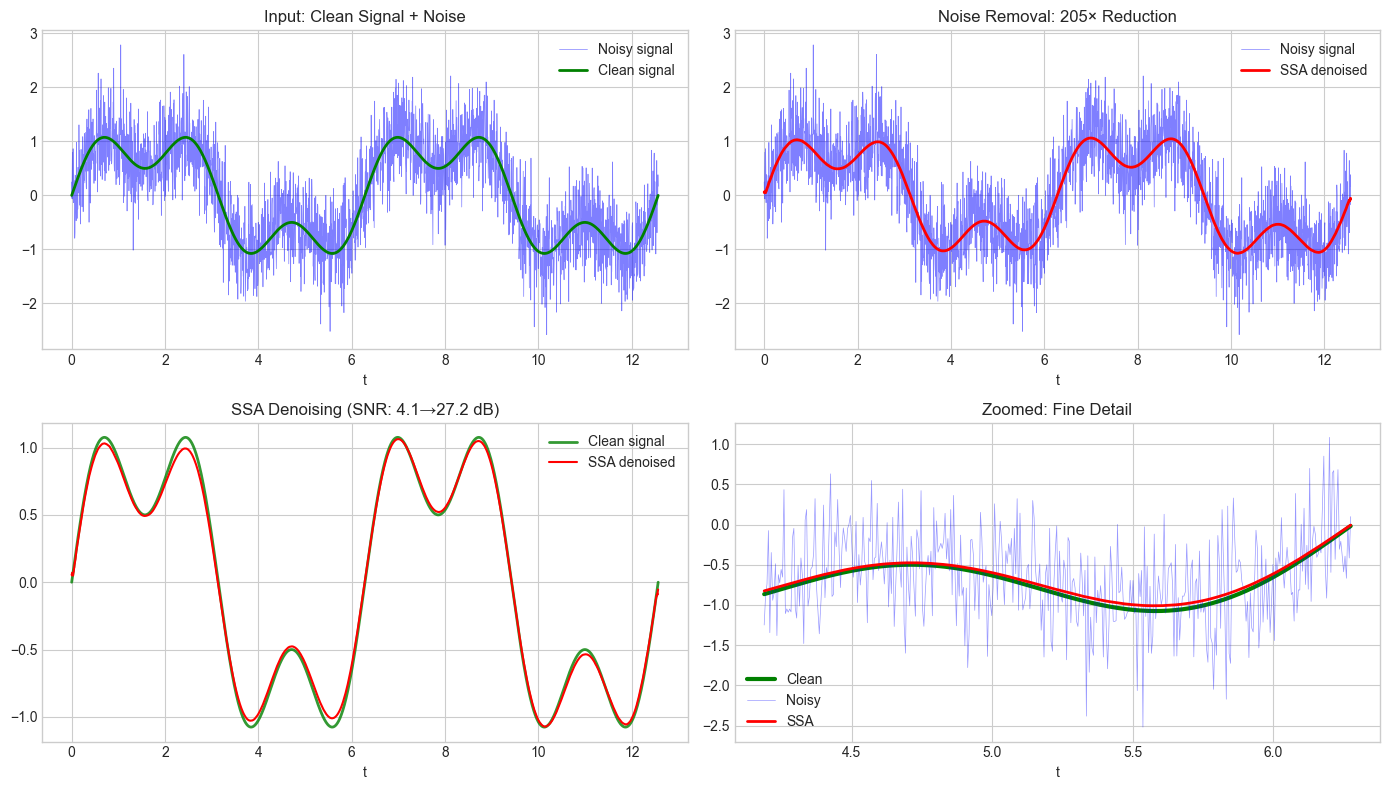

In [3]:
# Generate signal
N = 2500
t = np.linspace(0, 4*np.pi, N)

clean_signal = np.sin(t) + 0.5*np.sin(3*t)
noise = 0.5 * np.random.randn(N)
noisy_signal = clean_signal + noise

# Denoise with ensemble
denoised = ensemble_denoise(noisy_signal)
extracted_noise = noisy_signal - denoised

# Create SSA for visualization
ssa_viz = SSA(noisy_signal, L=N//2)
ssa_viz.decompose(k=30)

# Metrics
snr_before = 10 * np.log10(np.var(clean_signal) / np.var(noise))
snr_after = 10 * np.log10(np.var(clean_signal) / np.var(denoised - clean_signal))

# PLOT
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Top-left: Input (stays same)
axes[0, 0].plot(t, noisy_signal, 'b-', lw=0.5, alpha=0.5, label='Noisy signal')
axes[0, 0].plot(t, clean_signal, 'g-', lw=2, label='Clean signal')
axes[0, 0].set_title('Input: Clean Signal + Noise')
axes[0, 0].legend()
axes[0, 0].set_xlabel('t')

# Top-right: Noise Removal (was bottom-right)
axes[0, 1].plot(t, noisy_signal, 'b-', lw=0.5, alpha=0.5, label='Noisy signal')
axes[0, 1].plot(t, denoised, 'r-', lw=2, label='SSA denoised')
axes[0, 1].set_title(f'Noise Removal: {10**((snr_after-snr_before)/10):.0f}× Reduction')
axes[0, 1].legend()
axes[0, 1].set_xlabel('t')

# Bottom-left: SSA accuracy (was top-right)
axes[1, 0].plot(t, clean_signal, 'g-', lw=2, label='Clean signal', alpha=0.8)
axes[1, 0].plot(t, denoised, 'r-', lw=1.5, label='SSA denoised')
axes[1, 0].set_title(f'SSA Denoising (SNR: {snr_before:.1f}→{snr_after:.1f} dB)')
axes[1, 0].legend()
axes[1, 0].set_xlabel('t')

# Bottom-right: Zoomed (was bottom-left)
z1, z2 = N//3, N//3 + N//6
axes[1, 1].plot(t[z1:z2], clean_signal[z1:z2], 'g-', lw=3, label='Clean')
axes[1, 1].plot(t[z1:z2], noisy_signal[z1:z2], 'b-', lw=0.5, alpha=0.4, label='Noisy')
axes[1, 1].plot(t[z1:z2], denoised[z1:z2], 'r-', lw=2, label='SSA')
axes[1, 1].set_title('Zoomed: Fine Detail')
axes[1, 1].legend()
axes[1, 1].set_xlabel('t')

plt.tight_layout()
plt.savefig('ssa_denoising_best.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

---
## 2. Trend Extraction

SSA extracts smooth trends without the lag of moving averages.

In [36]:
# Generate price-like series: trend + seasonality + noise
N = 600
t = np.arange(N)

trend = 100 + 0.05*t + 5*np.sin(2*np.pi*t/400)  # Slow drift + very slow cycle
seasonal = 3*np.sin(2*np.pi*t/50)  # ~50 period cycle
noise = 1.5*np.random.randn(N)

price = trend + seasonal + noise

# SSA trend extraction
ssa = SSA(price, L=120)
ssa.decompose(k=40)

ssa_trend = ssa.get_trend()  # Component 0

# Compare with moving averages
def moving_average(x, window):
    return np.convolve(x, np.ones(window)/window, mode='same')

ma_50 = moving_average(price, 50)
ma_100 = moving_average(price, 100)

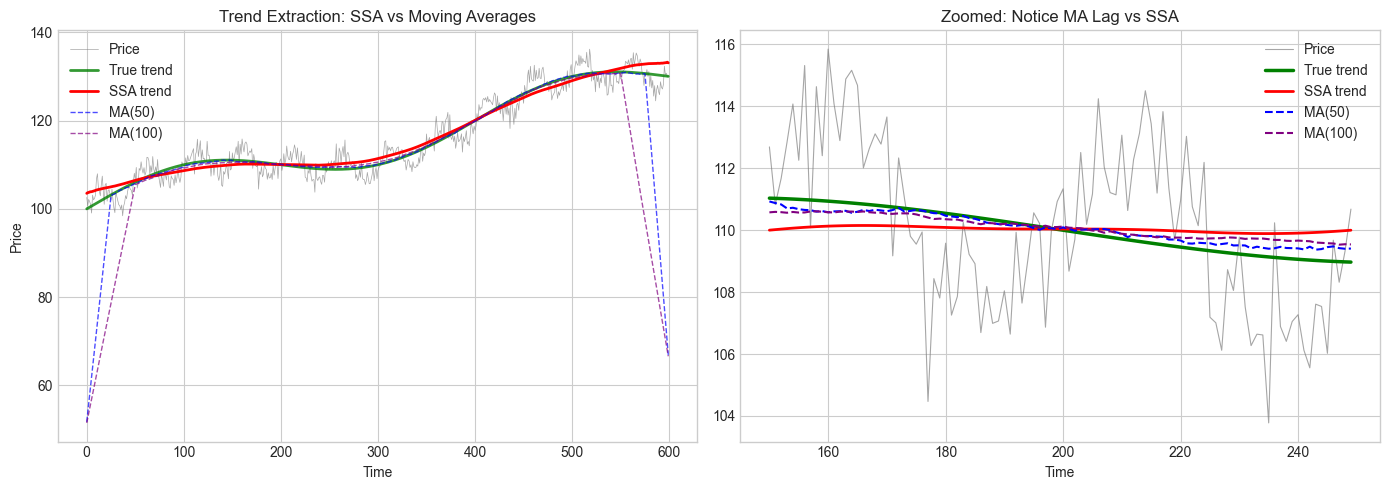

RMSE (SSA trend):  1.215
RMSE (MA-50):      9.550
RMSE (MA-100):     13.544


In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full view
axes[0].plot(t, price, 'gray', lw=0.5, alpha=0.7, label='Price')
axes[0].plot(t, trend, 'g-', lw=2, label='True trend', alpha=0.8)
axes[0].plot(t, ssa_trend, 'r-', lw=2, label='SSA trend')
axes[0].plot(t, ma_50, 'b--', lw=1, label='MA(50)', alpha=0.7)
axes[0].plot(t, ma_100, 'purple', ls='--', lw=1, label='MA(100)', alpha=0.7)
axes[0].set_title('Trend Extraction: SSA vs Moving Averages')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price')

# Zoom on turning point (to show lag difference)
zoom_start, zoom_end = 150, 250
axes[1].plot(t[zoom_start:zoom_end], price[zoom_start:zoom_end], 'gray', lw=0.8, alpha=0.7, label='Price')
axes[1].plot(t[zoom_start:zoom_end], trend[zoom_start:zoom_end], 'g-', lw=2.5, label='True trend')
axes[1].plot(t[zoom_start:zoom_end], ssa_trend[zoom_start:zoom_end], 'r-', lw=2, label='SSA trend')
axes[1].plot(t[zoom_start:zoom_end], ma_50[zoom_start:zoom_end], 'b--', lw=1.5, label='MA(50)')
axes[1].plot(t[zoom_start:zoom_end], ma_100[zoom_start:zoom_end], 'purple', ls='--', lw=1.5, label='MA(100)')
axes[1].set_title('Zoomed: Notice MA Lag vs SSA')
axes[1].legend()
axes[1].set_xlabel('Time')

plt.tight_layout()
plt.savefig('ssa_trend.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute RMSE
print(f"RMSE (SSA trend):  {np.sqrt(np.mean((ssa_trend - trend)**2)):.3f}")
print(f"RMSE (MA-50):      {np.sqrt(np.mean((ma_50 - trend)**2)):.3f}")
print(f"RMSE (MA-100):     {np.sqrt(np.mean((ma_100 - trend)**2)):.3f}")

---
## 3. Periodic Component Extraction

SSA identifies periodic signals as pairs of components with nearly equal singular values.

In [6]:
# Generate multi-frequency signal
N = 500
t = np.arange(N)

trend = 50 + 0.02*t
period1 = 4*np.sin(2*np.pi*t/60)   # Period 60
period2 = 2*np.sin(2*np.pi*t/25)   # Period 25 
period3 = 1*np.sin(2*np.pi*t/12)   # Period 12
noise = 0.8*np.random.randn(N)

signal = trend + period1 + period2 + period3 + noise

# SSA decomposition
ssa = SSA(signal, L=100)
ssa.decompose(k=20)

# Find periodic pairs automatically
pairs = ssa.find_periodic_pairs(max_pairs=10, sv_tol=0.15, wcorr_thresh=0.4)
print(f"Detected periodic pairs: {pairs}")

# Extract components
ssa_trend = ssa.reconstruct([0])

# Try to identify which pair corresponds to which frequency
if len(pairs) >= 1:
    ssa_period1 = ssa.reconstruct(list(pairs[0]))
if len(pairs) >= 2:
    ssa_period2 = ssa.reconstruct(list(pairs[1]))
if len(pairs) >= 3:
    ssa_period3 = ssa.reconstruct(list(pairs[2]))

Detected periodic pairs: [(np.int32(1), np.int32(2)), (np.int32(3), np.int32(4)), (np.int32(5), np.int32(6)), (np.int32(7), np.int32(9)), (np.int32(8), np.int32(10)), (np.int32(11), np.int32(12)), (np.int32(13), np.int32(16)), (np.int32(14), np.int32(15)), (np.int32(17), np.int32(18))]


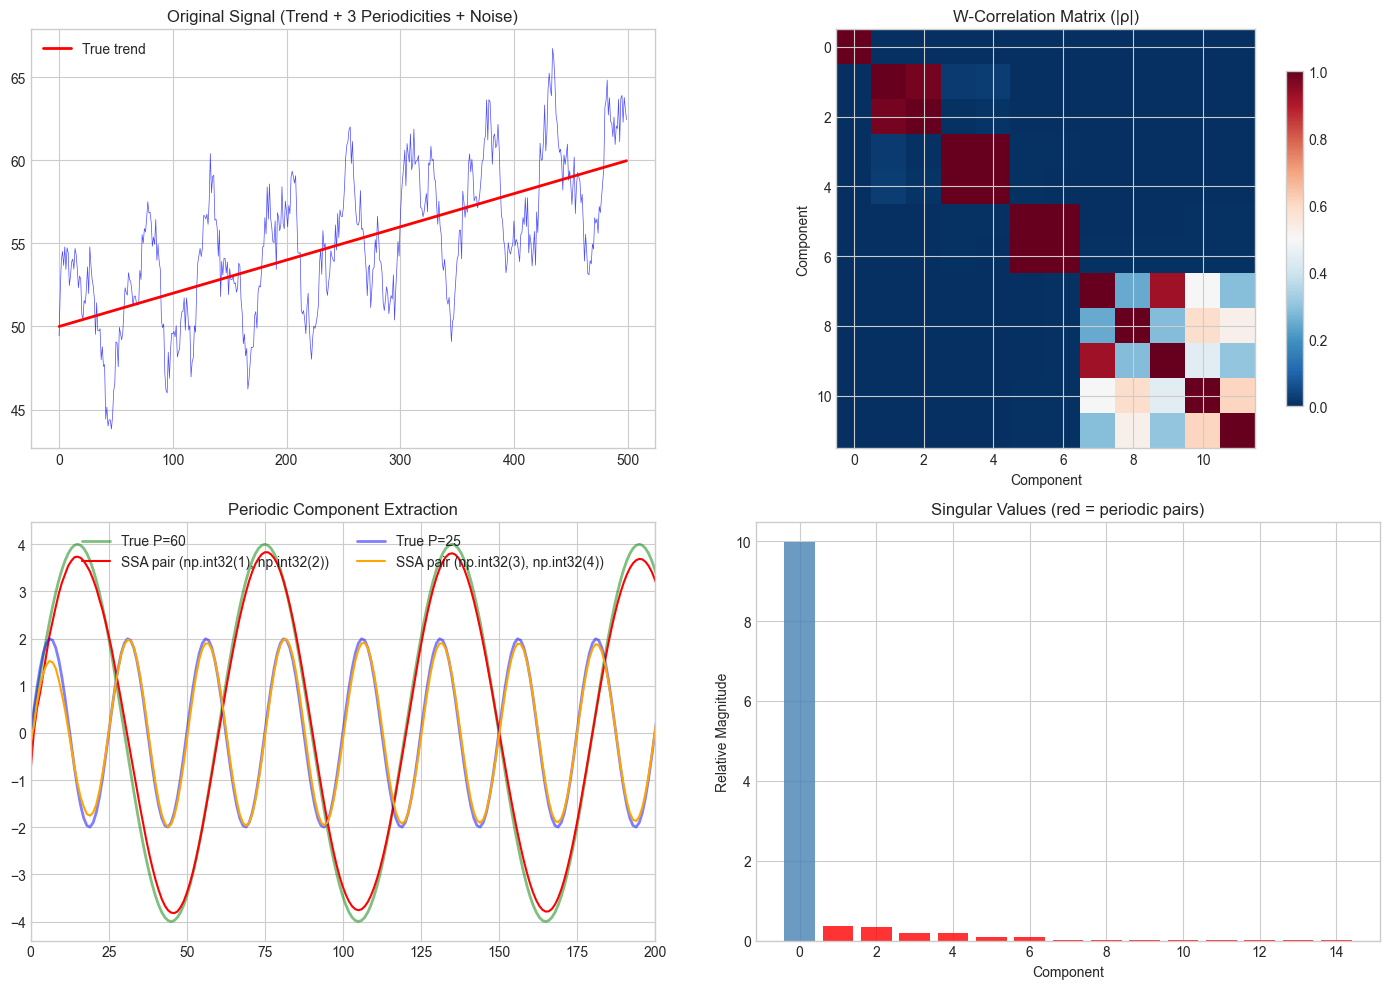

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original signal
axes[0, 0].plot(t, signal, 'b-', lw=0.5, alpha=0.7)
axes[0, 0].plot(t, trend, 'r-', lw=2, label='True trend')
axes[0, 0].set_title('Original Signal (Trend + 3 Periodicities + Noise)')
axes[0, 0].legend()

# W-correlation matrix
W = ssa.wcorr_matrix()
im = axes[0, 1].imshow(np.abs(W[:12, :12]), cmap='RdBu_r', vmin=0, vmax=1)
axes[0, 1].set_title('W-Correlation Matrix (|ρ|)')
axes[0, 1].set_xlabel('Component')
axes[0, 1].set_ylabel('Component')
plt.colorbar(im, ax=axes[0, 1], shrink=0.8)

# Extracted periodicities
axes[1, 0].plot(t, period1, 'g-', lw=2, alpha=0.5, label='True P=60')
if len(pairs) >= 1:
    axes[1, 0].plot(t, ssa_period1, 'r-', lw=1.5, label=f'SSA pair {pairs[0]}')
axes[1, 0].plot(t, period2, 'b-', lw=2, alpha=0.5, label='True P=25')
if len(pairs) >= 2:
    axes[1, 0].plot(t, ssa_period2, 'orange', lw=1.5, label=f'SSA pair {pairs[1]}')
axes[1, 0].set_title('Periodic Component Extraction')
axes[1, 0].legend(ncol=2)
axes[1, 0].set_xlim(0, 200)  # Zoom for clarity

# Singular value spectrum with pairs highlighted
n_show = 15
sigmas = [np.sqrt(ssa.variance_explained(i, i) * 100) for i in range(n_show)]  # Relative scale
colors = ['steelblue'] * n_show
for p in pairs:
    for idx in p:
        if idx < n_show:
            colors[idx] = 'red'

axes[1, 1].bar(range(n_show), sigmas, color=colors, alpha=0.8)
axes[1, 1].set_title('Singular Values (red = periodic pairs)')
axes[1, 1].set_xlabel('Component')
axes[1, 1].set_ylabel('Relative Magnitude')

plt.tight_layout()
plt.savefig('ssa_periodic.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Forecasting with LRF

SSA uses the Linear Recurrence Formula to extrapolate the signal.

In [38]:
# Generate signal with trend + seasonality
N = 400
N_forecast = 80
t_full = np.arange(N + N_forecast)

# True signal (known for entire range)
true_trend = 100 + 0.03*t_full
true_seasonal = 5*np.sin(2*np.pi*t_full/50)
true_signal = true_trend + true_seasonal

# Observed signal (only first N points, with noise)
noise = 1.0*np.random.randn(N)
observed = true_signal[:N] + noise

# Fit SSA on observed data
ssa = SSA(observed, L=80)
ssa.decompose(k=20)

# Forecast
signal_components = [0, 1, 2]  # Trend + first periodic pair
full_reconstruction = ssa.forecast_full(signal_components, N_forecast)

reconstruction = full_reconstruction[:N]
forecast = full_reconstruction[N:]

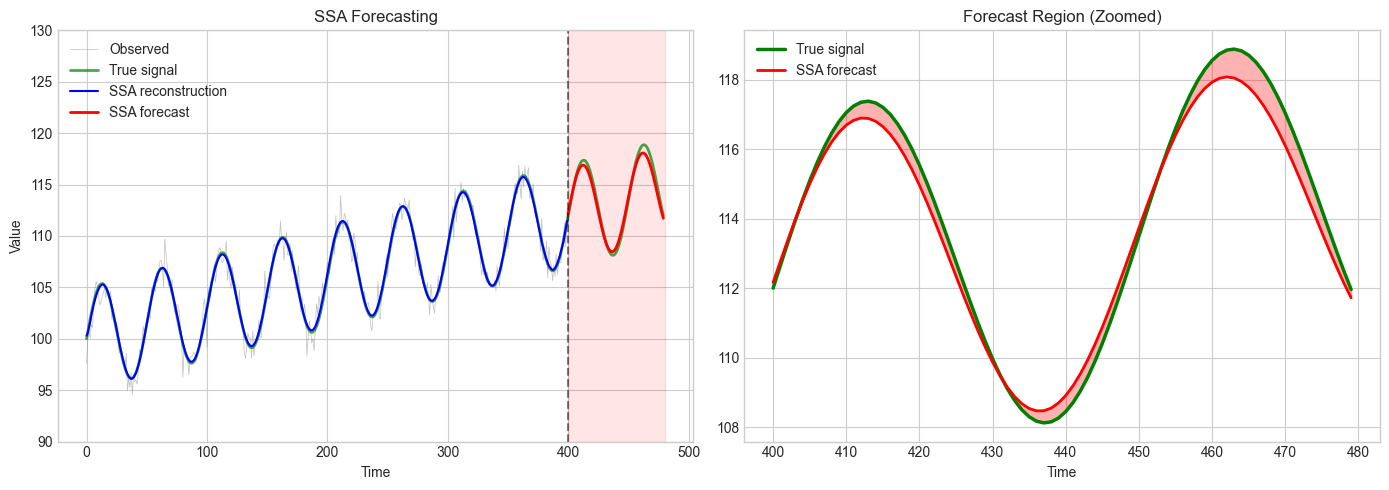

Forecast RMSE: 0.507
Forecast MAPE: 0.38%


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full view
axes[0].plot(t_full[:N], observed, 'gray', lw=0.5, alpha=0.5, label='Observed')
axes[0].plot(t_full, true_signal, 'g-', lw=2, alpha=0.7, label='True signal')
axes[0].plot(t_full[:N], reconstruction, 'b-', lw=1.5, label='SSA reconstruction')
axes[0].plot(t_full[N:], forecast, 'r-', lw=2, label='SSA forecast')
axes[0].axvline(x=N, color='black', linestyle='--', alpha=0.5)
axes[0].fill_between([N, N+N_forecast], -10, 200, alpha=0.1, color='red')
axes[0].set_title('SSA Forecasting')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].set_ylim(90, 130)

# Forecast zoom
t_forecast = t_full[N:]
axes[1].plot(t_forecast, true_signal[N:], 'g-', lw=2.5, label='True signal')
axes[1].plot(t_forecast, forecast, 'r-', lw=2, label='SSA forecast')
axes[1].fill_between(t_forecast, true_signal[N:], forecast, alpha=0.3, color='red')
axes[1].set_title('Forecast Region (Zoomed)')
axes[1].legend()
axes[1].set_xlabel('Time')

plt.tight_layout()
plt.savefig('ssa_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute forecast error
forecast_rmse = np.sqrt(np.mean((forecast - true_signal[N:])**2))
forecast_mape = np.mean(np.abs((forecast - true_signal[N:]) / true_signal[N:])) * 100
print(f"Forecast RMSE: {forecast_rmse:.3f}")
print(f"Forecast MAPE: {forecast_mape:.2f}%")

---
## 5. MSSA: Multivariate Analysis

MSSA extracts common factors from correlated time series.

In [40]:
# Simulate 4 correlated "sector ETFs"
N = 400
t = np.arange(N)

# Common market factor
market = 100 + 0.05*t + 8*np.sin(2*np.pi*t/100)

# Sector-specific factors
sector_betas = [1.0, 0.8, 1.2, 0.6]  # Market exposure
sector_offsets = [0, 20, -10, 40]  # Base level
sector_noise = [1.5, 2.0, 1.8, 2.5]  # Idiosyncratic vol

# Generate series
X = np.zeros((4, N))
for i in range(4):
    X[i] = sector_offsets[i] + sector_betas[i] * market + sector_noise[i] * np.random.randn(N)

# Apply MSSA
mssa = MSSA(X, L=80)
mssa.decompose(k=15)

print(f"Variance explained by first 3 components: {mssa.variance_explained(0, 2):.1%}")

Variance explained by first 3 components: 100.0%


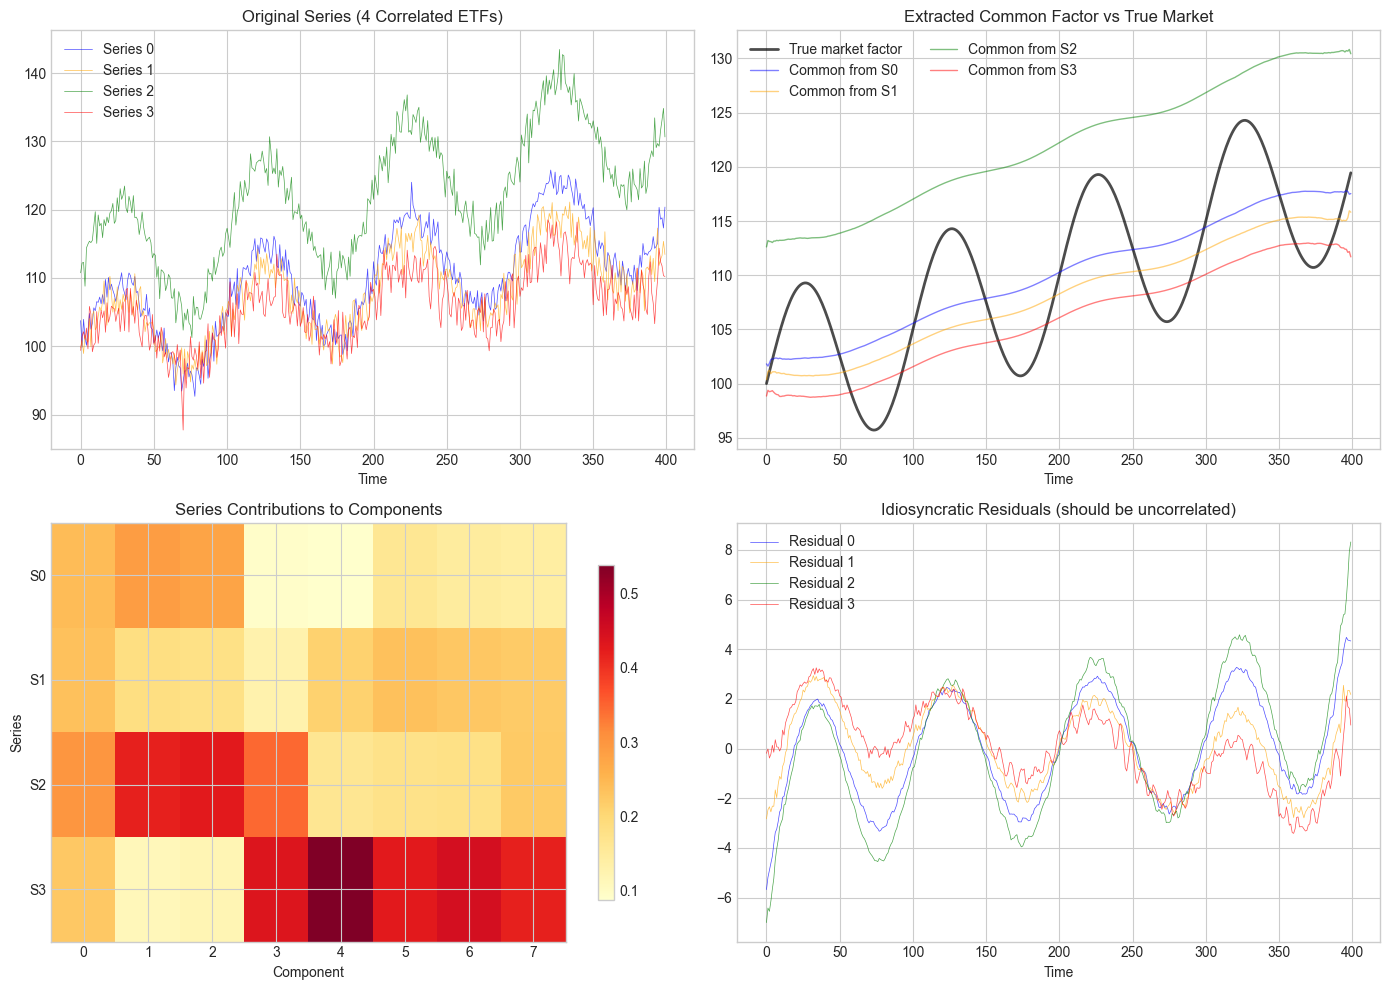


Residual correlations (should be low):
  Series 0 vs 1: 0.844
  Series 0 vs 2: 0.983
  Series 0 vs 3: 0.506
  Series 1 vs 2: 0.748
  Series 1 vs 3: 0.876
  Series 2 vs 3: 0.364


In [41]:
# Extract common factor from each series
common = mssa.reconstruct_all([0])  # First component = market

# Series contributions
contrib = mssa.series_contributions()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original series
colors = ['blue', 'orange', 'green', 'red']
for i in range(4):
    axes[0, 0].plot(t, X[i], color=colors[i], lw=0.5, alpha=0.7, label=f'Series {i}')
axes[0, 0].set_title('Original Series (4 Correlated ETFs)')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Time')

# Extracted common factor vs true market
axes[0, 1].plot(t, market, 'k-', lw=2, label='True market factor', alpha=0.7)
for i in range(4):
    # Scale common factor to match market (different betas)
    scaled = common[i] - np.mean(common[i]) + np.mean(market)
    axes[0, 1].plot(t, common[i], color=colors[i], lw=1, alpha=0.5, label=f'Common from S{i}')
axes[0, 1].set_title('Extracted Common Factor vs True Market')
axes[0, 1].legend(ncol=2)
axes[0, 1].set_xlabel('Time')

# Series contributions heatmap
im = axes[1, 0].imshow(contrib[:, :8], aspect='auto', cmap='YlOrRd')
axes[1, 0].set_title('Series Contributions to Components')
axes[1, 0].set_xlabel('Component')
axes[1, 0].set_ylabel('Series')
axes[1, 0].set_yticks(range(4))
axes[1, 0].set_yticklabels([f'S{i}' for i in range(4)])
plt.colorbar(im, ax=axes[1, 0], shrink=0.8)

# Residuals (idiosyncratic)
residuals = mssa.reconstruct_all(list(range(2, 10)))  # Components 2+ = idiosyncratic
for i in range(4):
    axes[1, 1].plot(t, residuals[i], color=colors[i], lw=0.5, alpha=0.7, label=f'Residual {i}')
axes[1, 1].set_title('Idiosyncratic Residuals (should be uncorrelated)')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Time')

plt.tight_layout()
plt.savefig('mssa_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute residual correlations
print("\nResidual correlations (should be low):")
for i in range(4):
    for j in range(i+1, 4):
        corr = np.corrcoef(residuals[i], residuals[j])[0, 1]
        print(f"  Series {i} vs {j}: {corr:.3f}")

---
## 6. Performance Benchmark

Compare decomposition methods and measure throughput.

In [42]:
import time

# Generate large signal
N = 5000
L = 1000
k = 50

signal = np.cumsum(np.random.randn(N)) + 10*np.sin(2*np.pi*np.arange(N)/100)

print(f"Signal: N={N}, L={L}, k={k}")
print(f"Hankel matrix: {L} × {N-L+1} = {L*(N-L+1):,} elements")
print()

# Benchmark randomized SVD
start = time.perf_counter()
ssa = SSA(signal, L=L)
ssa.decompose(k=k, method='randomized')
elapsed = time.perf_counter() - start
print(f"Randomized SVD: {elapsed*1000:.1f} ms")

# Benchmark block method
start = time.perf_counter()
ssa2 = SSA(signal, L=L)
ssa2.decompose(k=k, method='block')
elapsed = time.perf_counter() - start
print(f"Block method:   {elapsed*1000:.1f} ms")

# Variance explained should be similar
print(f"\nVariance explained (first 10):")
print(f"  Randomized: {ssa.variance_explained(0, 9):.4f}")
print(f"  Block:      {ssa2.variance_explained(0, 9):.4f}")

Signal: N=5000, L=1000, k=50
Hankel matrix: 1000 × 4001 = 4,001,000 elements

Randomized SVD: 12.9 ms
Block method:   391.1 ms

Variance explained (first 10):
  Randomized: 0.9904
  Block:      0.9888


---
## Summary

This MKL-optimized SSA implementation provides:

| Feature | Method | Typical Use |
|---------|--------|-------------|
| **Denoising** | `reconstruct([0..k])` | Clean price data |
| **Trend** | `get_trend()` | Identify direction |
| **Periodicity** | `find_periodic_pairs()` | Seasonality detection |
| **Forecast** | `forecast()` | Price prediction |
| **Multivariate** | `MSSA` | Pairs trading, factor extraction |

Performance: ~20-40ms for N=5000, L=1000, k=50 using randomized SVD.

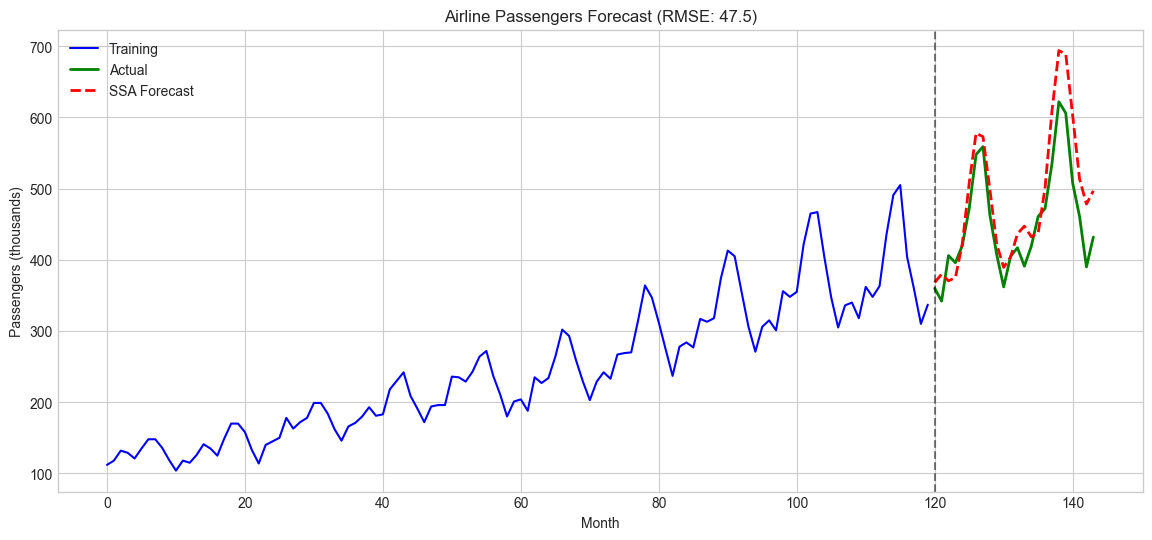

In [43]:
# Built into many libraries, or use this URL
import pandas as pd

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
passengers = df['Passengers'].values.astype(float)

N = len(passengers)
N_train = N - 24  # Hold out 2 years
train = passengers[:N_train]
test = passengers[N_train:]

ssa = SSA(train, L=N_train//2)
ssa.decompose(k=30)
forecast = ssa.forecast([0, 1, 2, 3, 4, 5, 6], n_forecast=24)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(N_train), train, 'b-', lw=1.5, label='Training')
ax.plot(range(N_train, N), test, 'g-', lw=2, label='Actual')
ax.plot(range(N_train, N), forecast, 'r--', lw=2, label='SSA Forecast')
ax.axvline(N_train, color='k', ls='--', alpha=0.5)
ax.set_title(f'Airline Passengers Forecast (RMSE: {np.sqrt(np.mean((test-forecast)**2)):.1f})')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('Passengers (thousands)')
plt.savefig('linkedin_forecast.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

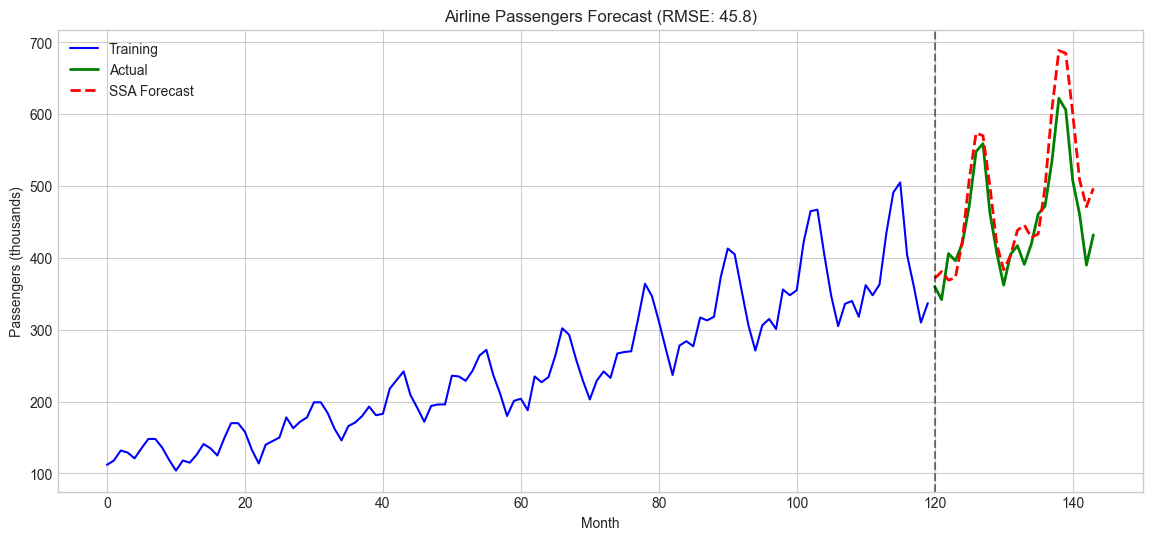

In [44]:
# Built into many libraries, or use this URL
import pandas as pd

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
passengers = df['Passengers'].values.astype(float)

N = len(passengers)
N_train = N - 24  # Hold out 2 years
train = passengers[:N_train]
test = passengers[N_train:]

ssa = SSA(train, L=N_train//2)
ssa.decompose(k=25)
forecast = ssa.forecast([0, 1, 2, 3, 4, 5], n_forecast=24)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(range(N_train), train, 'b-', lw=1.5, label='Training')
ax.plot(range(N_train, N), test, 'g-', lw=2, label='Actual')
ax.plot(range(N_train, N), forecast, 'r--', lw=2, label='SSA Forecast')
ax.axvline(N_train, color='k', ls='--', alpha=0.5)
ax.set_title(f'Airline Passengers Forecast (RMSE: {np.sqrt(np.mean((test-forecast)**2)):.1f})')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('Passengers (thousands)')
plt.show()

In [45]:
import yfinance as yf

# Option 1: Bitcoin - wild trends, no clear seasonality
btc = yf.download('BTC-USD', period='5y', interval='1d', progress=False)['Close'].values.flatten()

# Option 2: VIX (Volatility Index) - spiky, regime changes
vix = yf.download('^VIX', period='5y', interval='1d', progress=False)['Close'].values.flatten()

# Option 3: 10-Year Treasury Yield - interest rate trends
tlt = yf.download('^TNX', period='10y', interval='1d', progress=False)['Close'].values.flatten()

# Option 4: Gold - safe haven, complex
gold = yf.download('GC=F', period='5y', interval='1d', progress=False)['Close'].values.flatten()

# Option 5: Oil - geopolitical shocks
oil = yf.download('CL=F', period='5y', interval='1d', progress=False)['Close'].values.flatten()

C:\Users\Tugbars\AppData\Local\Temp\ipykernel_5736\1342291715.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', period='5y', interval='1d', progress=False)['Close'].values.flatten()
C:\Users\Tugbars\AppData\Local\Temp\ipykernel_5736\1342291715.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', period='5y', interval='1d', progress=False)['Close'].values.flatten()
C:\Users\Tugbars\AppData\Local\Temp\ipykernel_5736\1342291715.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tlt = yf.download('^TNX', period='10y', interval='1d', progress=False)['Close'].values.flatten()
C:\Users\Tugbars\AppData\Local\Temp\ipykernel_5736\1342291715.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download('GC=F', period='5y', interval='1d', progress=False)['Close'].values.flatten()
C:\Users\Tugbars\

C:\Users\Tugbars\AppData\Local\Temp\ipykernel_5736\2923362447.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', period='4y', interval='1d', progress=False)['Close'].values.flatten()


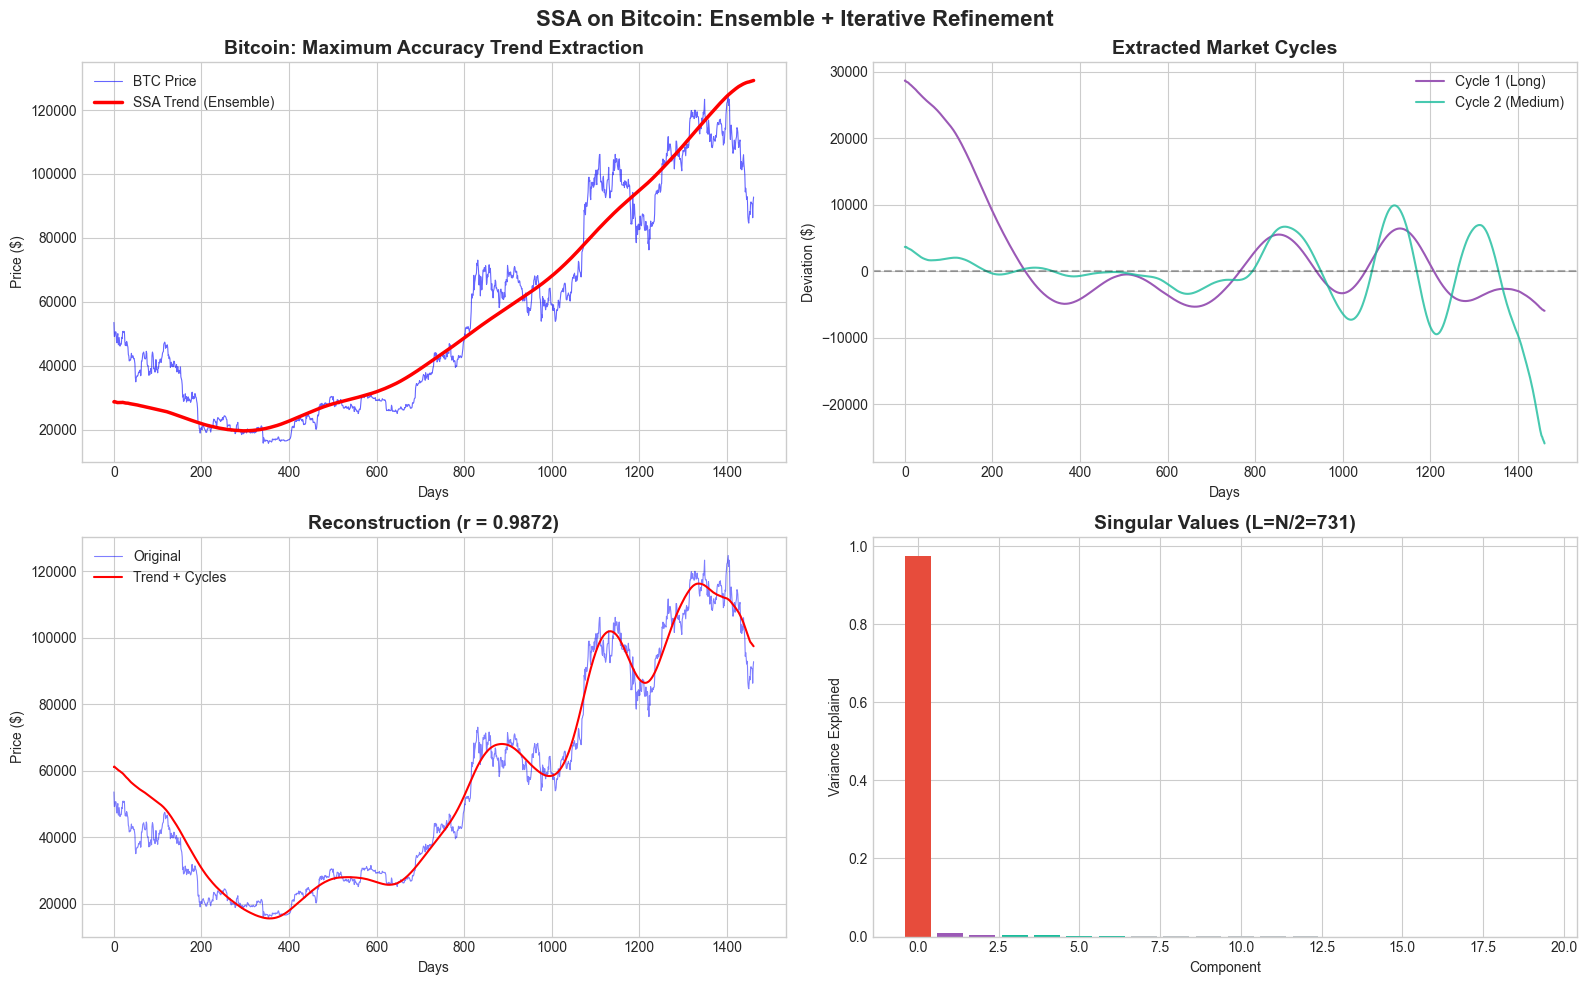

Method: Ensemble (L = ['N/4', 'N/3', 'N/2', 'N/2']) + Iterative Refinement
Reconstruction correlation: 0.9872
Trend variance: 97.4%
Top 7 components: 99.6%


In [46]:
# Fetch Bitcoin
btc = yf.download('BTC-USD', period='4y', interval='1d', progress=False)['Close'].values.flatten()
btc = btc[~np.isnan(btc)]

N = len(btc)

# === MAXIMUM ACCURACY ENSEMBLE ===
L_fracs = [1/4, 1/3, 2/5, 1/2]  # More L values, up to N/2
weights = np.array([1, 2, 3, 4], dtype=float)
weights /= weights.sum()

trends = []
cycles1 = []
cycles2 = []

for frac in L_fracs:
    L = int(N * frac)
    k = min(80, L - 1)  # More components
    
    ssa = SSA(btc, L=L)
    ssa.decompose(k=k)
    
    # Auto-select trend components via cumulative variance
    var = [ssa.variance_explained(i, i) for i in range(k)]
    
    # Trend: first component(s) until big gap
    ratios = [var[i] / (var[i+1] + 1e-12) for i in range(min(10, k-1))]
    trend_cut = 1  # At minimum, component 0
    
    trends.append(ssa.reconstruct([0]))
    cycles1.append(ssa.reconstruct([1, 2]))
    cycles2.append(ssa.reconstruct([3, 4, 5, 6]))

# Weighted ensemble
trend = sum(w * t for w, t in zip(weights, trends))
cycle1 = sum(w * c for w, c in zip(weights, cycles1))
cycle2 = sum(w * c for w, c in zip(weights, cycles2))

# Iterative refinement on residual
residual = btc - trend
ssa_refine = SSA(residual, L=N//2)
ssa_refine.decompose(k=30)

# Check if residual has structure (not just noise)
var_res = [ssa_refine.variance_explained(i, i) for i in range(30)]
if var_res[0] > 0.3:  # Significant structure remains
    trend_refine = ssa_refine.reconstruct([0])
    trend = trend + 0.5 * trend_refine  # Partial correction

# Full SSA for visualization
ssa_viz = SSA(btc, L=N//2)
ssa_viz.decompose(k=50)

# === PLOT ===
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Price + Trend
axes[0, 0].plot(btc, 'b-', lw=0.8, alpha=0.6, label='BTC Price')
axes[0, 0].plot(trend, 'r-', lw=2.5, label='SSA Trend (Ensemble)')
axes[0, 0].set_title('Bitcoin: Maximum Accuracy Trend Extraction', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Price ($)')

# Cycles
axes[0, 1].plot(cycle1, '#9b59b6', lw=1.5, label='Cycle 1 (Long)')
axes[0, 1].plot(cycle2, '#1abc9c', lw=1.5, alpha=0.8, label='Cycle 2 (Medium)')
axes[0, 1].axhline(0, color='k', ls='--', alpha=0.3)
axes[0, 1].set_title('Extracted Market Cycles', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Deviation ($)')

# Price vs Trend+Cycles
reconstruction = trend + cycle1 + cycle2
axes[1, 0].plot(btc, 'b-', lw=0.8, alpha=0.5, label='Original')
axes[1, 0].plot(reconstruction, 'r-', lw=1.5, label='Trend + Cycles')
corr = np.corrcoef(btc, reconstruction)[0, 1]
axes[1, 0].set_title(f'Reconstruction (r = {corr:.4f})', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Price ($)')

# Variance spectrum
variances = [ssa_viz.variance_explained(i, i) for i in range(20)]
colors = ['#e74c3c'] + ['#9b59b6']*2 + ['#1abc9c']*4 + ['#bdc3c7']*13
axes[1, 1].bar(range(20), variances, color=colors)
axes[1, 1].set_title(f'Singular Values (L=N/2={N//2})', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Component')
axes[1, 1].set_ylabel('Variance Explained')

plt.suptitle('SSA on Bitcoin: Ensemble + Iterative Refinement', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('linkedin_btc_max_accuracy.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Method: Ensemble (L = {[f'N/{int(1/f)}' for f in L_fracs]}) + Iterative Refinement")
print(f"Reconstruction correlation: {corr:.4f}")
print(f"Trend variance: {ssa_viz.variance_explained(0, 0):.1%}")
print(f"Top 7 components: {ssa_viz.variance_explained(0, 6):.1%}")

Signal: 6 sinusoids (rank 80), N=2000, L=1000
Input SNR:      3.4 dB
SSA SNR:        16.4 dB
Cadzow SNR:     18.5 dB (30 iterations)


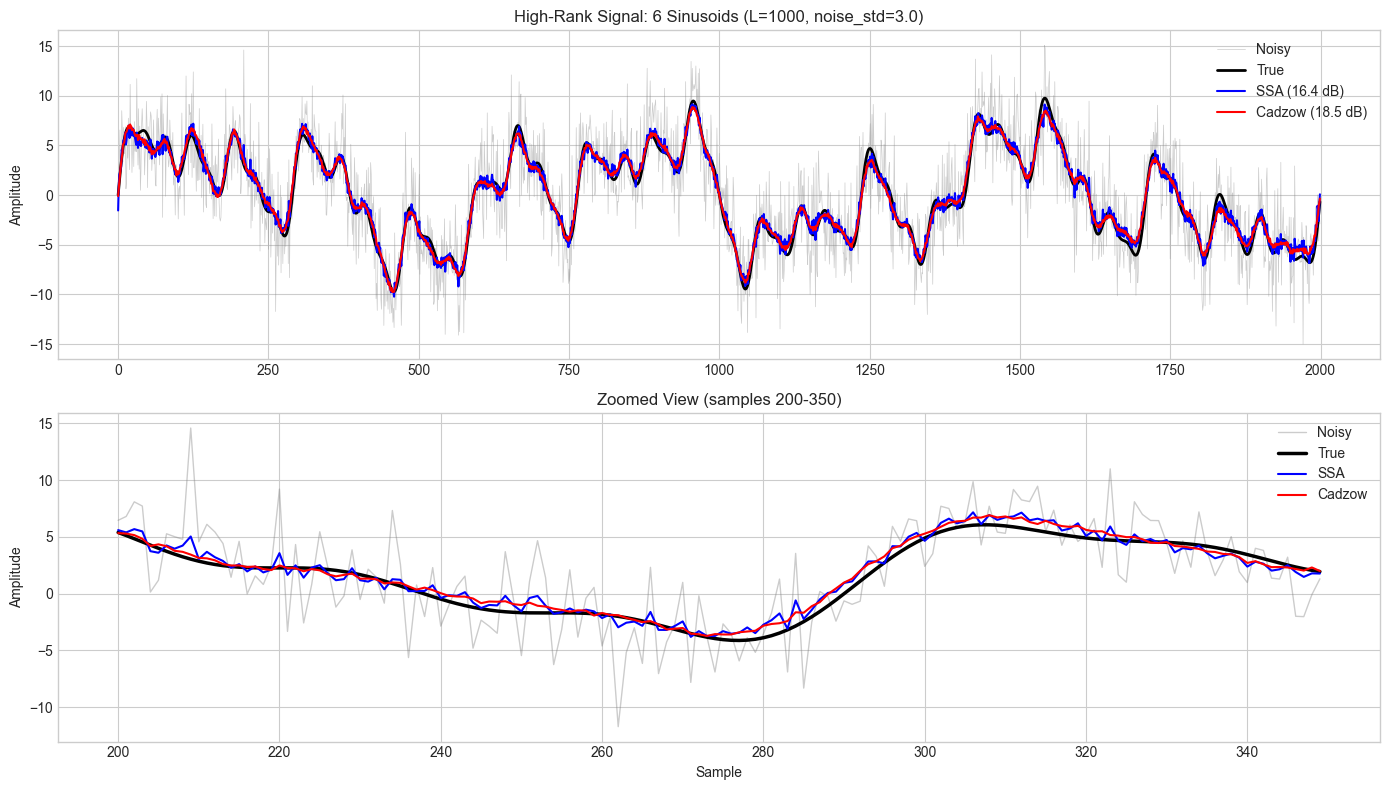

In [51]:
from ssa_wrapper import SSA, cadzow

# Generate high-rank signal: multiple sinusoids (rank 12)
N = 2000
L = N // 2
rank = 80
t = np.arange(N) / N

true_signal = (4.0 * np.sin(2 * np.pi * 3 * t) +
               3.0 * np.sin(2 * np.pi * 7 * t) +
               2.5 * np.sin(2 * np.pi * 13 * t) +
               2.0 * np.sin(2 * np.pi * 21 * t) +
               1.5 * np.sin(2 * np.pi * 34 * t) +
               1.0 * np.sin(2 * np.pi * 55 * t))

# Add heavy noise
np.random.seed(42)
noise_std = 3.0
noisy = true_signal + np.random.randn(N) * noise_std

# Single-pass SSA denoising
ssa = SSA(noisy, L=L)
ssa.decompose(k=rank)
ssa_result = ssa.reconstruct(list(range(rank)))

# Cadzow denoising
cadzow_res = cadzow(noisy, L=L, rank=rank, max_iter=30)

# Compute SNR
def snr(true, est):
    return 10 * np.log10(np.mean(true**2) / np.mean((true - est)**2))

print(f"Signal: 6 sinusoids (rank {rank}), N={N}, L={L}")
print(f"Input SNR:      {snr(true_signal, noisy):.1f} dB")
print(f"SSA SNR:        {snr(true_signal, ssa_result):.1f} dB")
print(f"Cadzow SNR:     {snr(true_signal, cadzow_res.signal):.1f} dB ({cadzow_res.iterations} iterations)")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full signal
axes[0].plot(noisy, 'gray', alpha=0.4, lw=0.5, label='Noisy')
axes[0].plot(true_signal, 'k-', lw=2, label='True')
axes[0].plot(ssa_result, 'b-', lw=1.5, label=f'SSA ({snr(true_signal, ssa_result):.1f} dB)')
axes[0].plot(cadzow_res.signal, 'r-', lw=1.5, label=f'Cadzow ({snr(true_signal, cadzow_res.signal):.1f} dB)')
axes[0].set_title(f'High-Rank Signal: 6 Sinusoids (L={L}, noise_std={noise_std})')
axes[0].legend(loc='upper right')
axes[0].set_ylabel('Amplitude')

# Zoomed view
z = slice(200, 350)
axes[1].plot(range(z.start, z.stop), noisy[z], 'gray', alpha=0.4, lw=1, label='Noisy')
axes[1].plot(range(z.start, z.stop), true_signal[z], 'k-', lw=2.5, label='True')
axes[1].plot(range(z.start, z.stop), ssa_result[z], 'b-', lw=1.5, label='SSA')
axes[1].plot(range(z.start, z.stop), cadzow_res.signal[z], 'r-', lw=1.5, label='Cadzow')
axes[1].set_title('Zoomed View (samples 200-350)')
axes[1].legend(loc='upper right')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('cadzow_comparison.png', dpi=250, bbox_inches='tight')
plt.show()

SPY Forecast (N=481, L=80, k=38)
Forecast horizon: 20 days

R-Forecast: RMSE=$7.92, MAPE=0.81%
V-Forecast: RMSE=$7.92, MAPE=0.81%


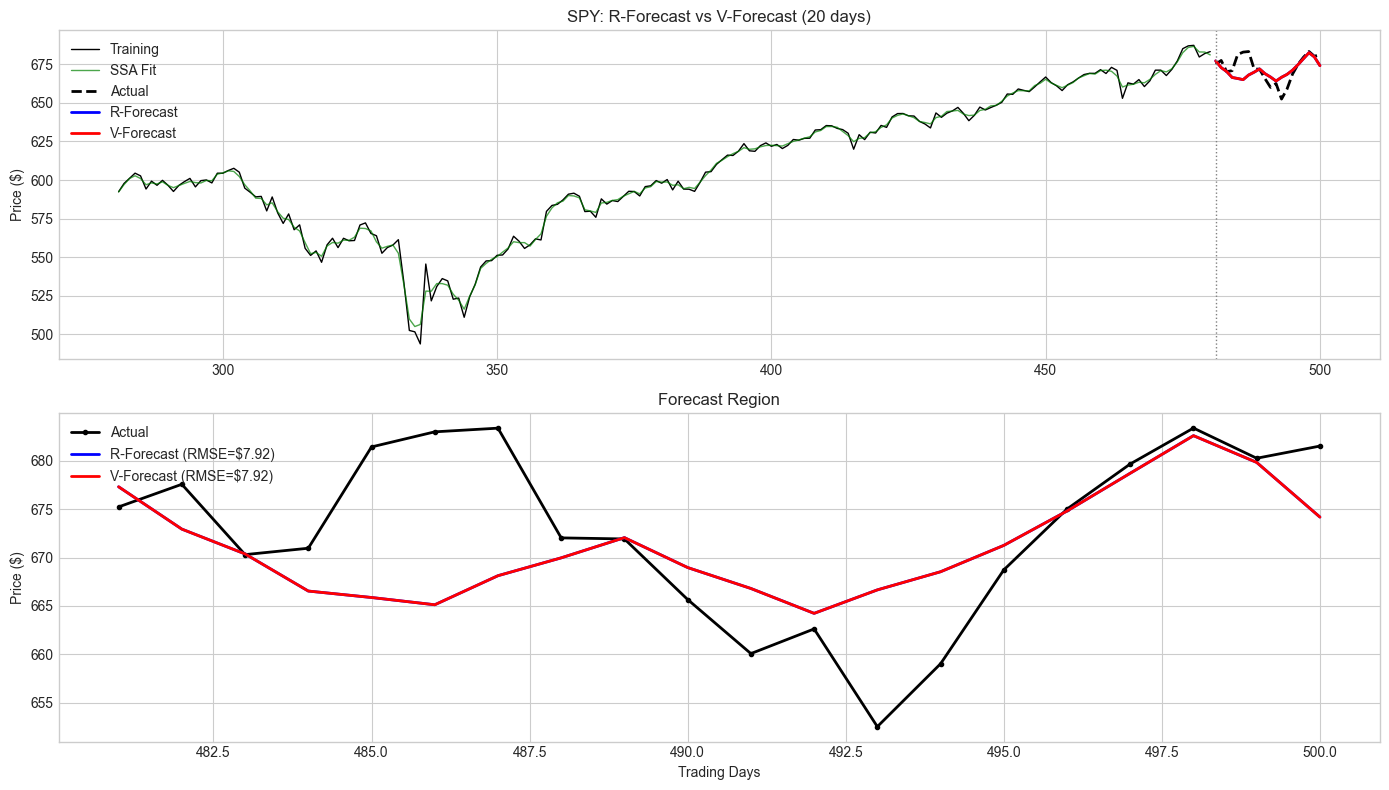

In [52]:
import yfinance as yf
from ssa_wrapper import SSA

# Download SPY data
ticker = yf.Ticker("SPY")
df = ticker.history(period="2y")
prices = df['Close'].values

N = len(prices)
n_forecast = 20  # ~1 months ahead
train_end = N - n_forecast
x_train = prices[:train_end]
x_true = prices[train_end:]

# SSA decomposition
L = 80  # ~6 months window
k = 38
ssa = SSA(x_train, L=L)
ssa.decompose(k=k)

group = list(range(k))
reconstructed = ssa.reconstruct(group)

# Forecast with both methods
r_forecast = ssa.forecast(group, n_forecast)
v_forecast = ssa.vforecast(group, n_forecast)

# Compute errors
def rmse(true, pred):
    return np.sqrt(np.mean((true - pred)**2))

def mape(true, pred):
    return 100 * np.mean(np.abs((true - pred) / true))

print(f"SPY Forecast (N={len(x_train)}, L={L}, k={k})")
print(f"Forecast horizon: {n_forecast} days")
print(f"\nR-Forecast: RMSE=${rmse(x_true, r_forecast):.2f}, MAPE={mape(x_true, r_forecast):.2f}%")
print(f"V-Forecast: RMSE=${rmse(x_true, v_forecast):.2f}, MAPE={mape(x_true, v_forecast):.2f}%")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

t_train = np.arange(train_end)
t_forecast = np.arange(train_end, N)

# Full view
axes[0].plot(t_train[-200:], x_train[-200:], 'k-', lw=1, label='Training')
axes[0].plot(t_train[-200:], reconstructed[-200:], 'g-', lw=1, alpha=0.7, label='SSA Fit')
axes[0].plot(t_forecast, x_true, 'k--', lw=2, label='Actual')
axes[0].plot(t_forecast, r_forecast, 'b-', lw=2, label=f'R-Forecast')
axes[0].plot(t_forecast, v_forecast, 'r-', lw=2, label=f'V-Forecast')
axes[0].axvline(x=train_end, color='gray', linestyle=':', lw=1)
axes[0].set_title(f'SPY: R-Forecast vs V-Forecast ({n_forecast} days)')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('Price ($)')

# Forecast region only
axes[1].plot(t_forecast, x_true, 'ko-', lw=2, markersize=3, label='Actual')
axes[1].plot(t_forecast, r_forecast, 'b-', lw=2, label=f'R-Forecast (RMSE=${rmse(x_true, r_forecast):.2f})')
axes[1].plot(t_forecast, v_forecast, 'r-', lw=2, label=f'V-Forecast (RMSE=${rmse(x_true, v_forecast):.2f})')
axes[1].set_title('Forecast Region')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlabel('Trading Days')

plt.tight_layout()
plt.savefig('forecast_finance.png', dpi=250, bbox_inches='tight')
plt.show()

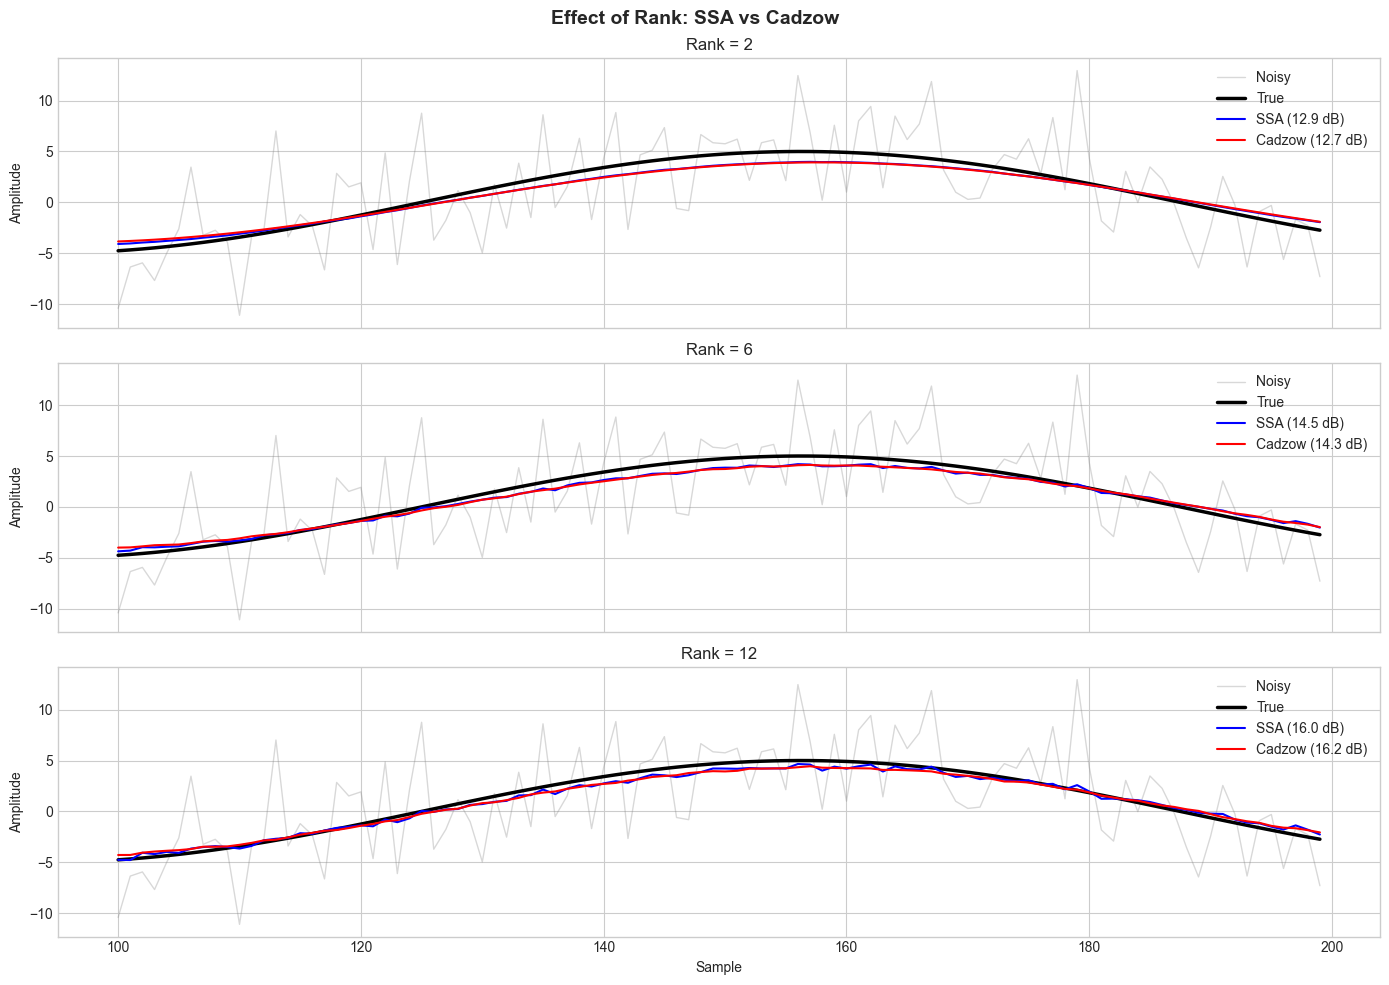

Rank   SSA SNR      Cadzow SNR   Cadzow Gain 
------------------------------------------
2      12.9         12.7         -0.20 dB
6      14.5         14.3         -0.15 dB
12     16.0         16.2         +0.20 dB


In [60]:
# Rank selection: Underfit vs Overfit vs Cadzow
import numpy as np
import matplotlib.pyplot as plt
from ssa_wrapper import SSA, cadzow

# Simple sine wave (true rank 2)
N = 500
L = N // 2
t = np.arange(N) / N
true_signal = 5.0 * np.sin(2 * np.pi * 8 * t)

np.random.seed(42)
noise_std = 4.0
noisy = true_signal + np.random.randn(N) * noise_std

def snr(true, est):
    return 10 * np.log10(np.mean(true**2) / np.mean((true - est)**2))

# Compare ranks
results = {}
for rank in [2, 6, 12]:
    ssa = SSA(noisy, L=L)
    ssa.decompose(k=rank)
    ssa_result = ssa.reconstruct(list(range(rank)))
    cadzow_res = cadzow(noisy, L=L, rank=rank, max_iter=30)
    results[rank] = {
        'ssa': ssa_result,
        'cadzow': cadzow_res.signal,
        'ssa_snr': snr(true_signal, ssa_result),
        'cadzow_snr': snr(true_signal, cadzow_res.signal)
    }

# Plot zoomed comparison
z = slice(100, 200)
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for ax, rank in zip(axes, [2, 6, 12]):
    r = results[rank]
    ax.plot(range(z.start, z.stop), noisy[z], 'gray', alpha=0.3, lw=1, label='Noisy')
    ax.plot(range(z.start, z.stop), true_signal[z], 'k-', lw=2.5, label='True')
    ax.plot(range(z.start, z.stop), r['ssa'][z], 'b-', lw=1.5, label=f"SSA ({r['ssa_snr']:.1f} dB)")
    ax.plot(range(z.start, z.stop), r['cadzow'][z], 'r-', lw=1.5, label=f"Cadzow ({r['cadzow_snr']:.1f} dB)")
    ax.set_title(f'Rank = {rank}')
    ax.legend(loc='upper right')
    ax.set_ylabel('Amplitude')

axes[2].set_xlabel('Sample')
plt.suptitle('Effect of Rank: SSA vs Cadzow', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print(f"{'Rank':<6} {'SSA SNR':<12} {'Cadzow SNR':<12} {'Cadzow Gain':<12}")
print("-" * 42)
for rank in [2, 6, 12]:
    r = results[rank]
    gain = r['cadzow_snr'] - r['ssa_snr']
    print(f"{rank:<6} {r['ssa_snr']:<12.1f} {r['cadzow_snr']:<12.1f} {gain:+.2f} dB")

Signal: N=500, 75 missing values (15.0%)
gap_mask sum: 75
result_iter.signal NaN count: 75
result_iter.n_gaps: 0
Sample filled values: [nan nan nan nan nan]
Sample true values:   [1.         0.99082474 0.99479726 1.02361606 1.08622542]

Iterative: 0 iterations, RMSE=nan
Simple:    1 pass,             RMSE=nan


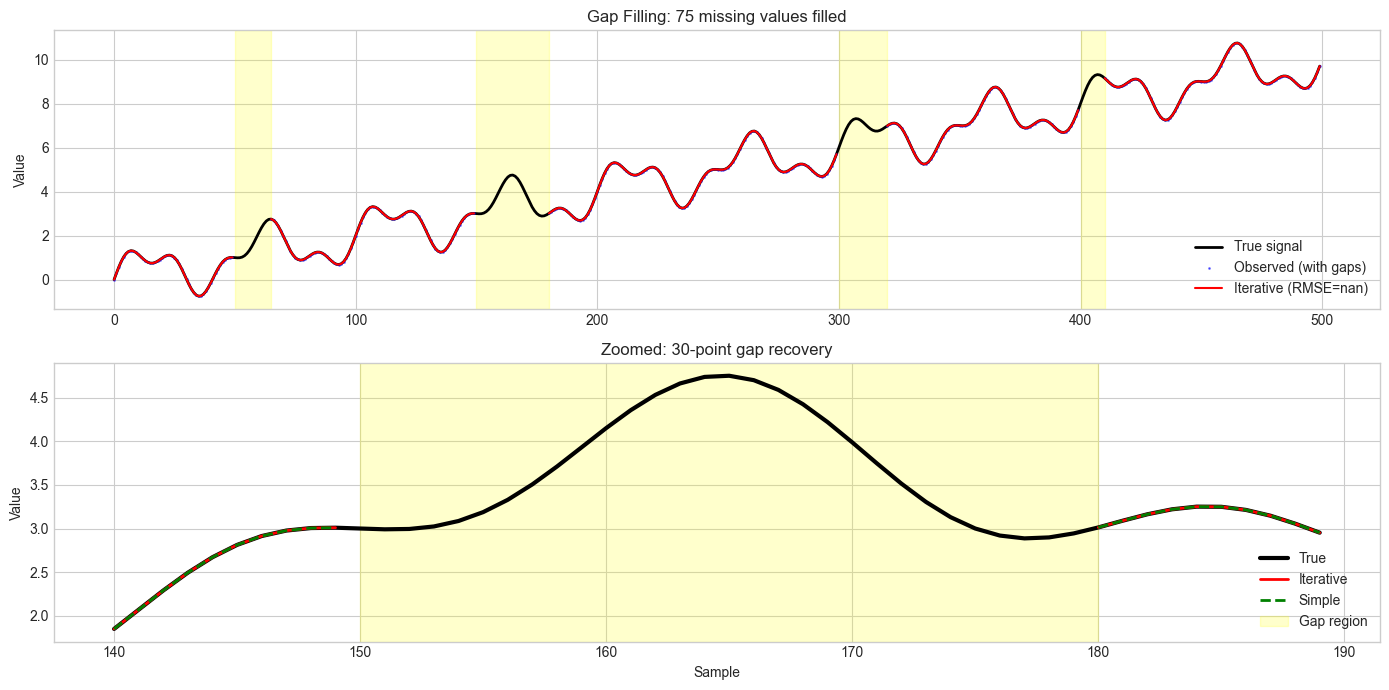

In [59]:
from ssa_wrapper import gapfill

# Generate signal with known structure
N = 500
t = np.arange(N)
true_signal = (np.sin(2 * np.pi * t / 50) + 
               0.5 * np.sin(2 * np.pi * t / 20) + 
               0.02 * t)  # trend + two cycles

# Create gaps (simulate missing data)
x = true_signal.copy()
gap_regions = [(50, 65), (150, 180), (300, 320), (400, 410)]  # (start, end)
for start, end in gap_regions:
    x[start:end] = np.nan

n_gaps = np.sum(np.isnan(x))
print(f"Signal: N={N}, {n_gaps} missing values ({100*n_gaps/N:.1f}%)")

# Fill gaps - iterative method (more accurate)
result_iter = gapfill(x.copy(), L=100, rank=6, max_iter=100, tol=1e-4, method="iterative")

print(f"gap_mask sum: {gap_mask.sum()}")
print(f"result_iter.signal NaN count: {np.isnan(result_iter.signal).sum()}")
print(f"result_iter.n_gaps: {result_iter.n_gaps}")
print(f"Sample filled values: {result_iter.signal[50:55]}")
print(f"Sample true values:   {true_signal[50:55]}")

# Fill gaps - simple method (faster)
result_simple = gapfill(x.copy(), L=100, rank=6, method="simple")

# Compute RMSE only at gap positions
gap_mask = np.isnan(x)
rmse_iter = np.sqrt(np.mean((result_iter.signal[gap_mask] - true_signal[gap_mask])**2))
rmse_simple = np.sqrt(np.mean((result_simple.signal[gap_mask] - true_signal[gap_mask])**2))

print(f"\nIterative: {result_iter.iterations} iterations, RMSE={rmse_iter:.4f}")
print(f"Simple:    1 pass,             RMSE={rmse_simple:.4f}")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 7))

# Full view
ax = axes[0]
ax.plot(t, true_signal, 'k-', lw=2, label='True signal')
ax.plot(t, x, 'b.', markersize=2, alpha=0.5, label='Observed (with gaps)')
ax.plot(t, result_iter.signal, 'r-', lw=1.5, label=f'Iterative (RMSE={rmse_iter:.4f})')
for start, end in gap_regions:
    ax.axvspan(start, end, alpha=0.2, color='yellow')
ax.set_title(f'Gap Filling: {n_gaps} missing values filled')
ax.legend(loc='lower right')
ax.set_ylabel('Value')

# Zoomed view on one gap
ax = axes[1]
z = slice(140, 190)  # Zoom on gap at 150-180
ax.plot(t[z], true_signal[z], 'k-', lw=3, label='True')
ax.plot(t[z], result_iter.signal[z], 'r-', lw=2, label='Iterative')
ax.plot(t[z], result_simple.signal[z], 'g--', lw=2, label='Simple')
ax.axvspan(150, 180, alpha=0.2, color='yellow', label='Gap region')
ax.set_title('Zoomed: 30-point gap recovery')
ax.legend(loc='lower right')
ax.set_xlabel('Sample')
ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig('gapfill_demo.png', dpi=200, bbox_inches='tight')
plt.show()